In [128]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

import trimap
import numpy as np
import os
import pickle
from sklearn.decomposition import PCA
import sys
sys.path.append("..")
from scripts.utils import get_path
from vis_utils.loaders import load_dataset
from vis_utils.plot import hists_from_graph_embd, plot_scatter
from vis_utils.utils import kNN_graph, kNN_dists, acc_kNN, corr_pdist_subsample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [129]:
root_path = get_path("data")
fig_path = get_path("figures")

In [130]:
# set up matplotlib
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [131]:
dataset = "mnist"
k=15
seeds = [0, 1, 2]

In [132]:
# get data
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset)

In [133]:
pca50 = np.load(os.path.join(root_path, dataset, "pca50.npy"))

In [134]:
knn_graph = kNN_graph(pca50.astype("float"),
                      k,
                      metric="euclidean").cpu().numpy()
knn_dists = kNN_dists(pca50.astype("float"),
                      k,
                      metric="euclidean").cpu().numpy()

In [148]:
trimappers = {}

In [149]:
mode = "vanilla"
trimappers[mode] = []
for seed in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"trimap_mode_{mode}_seed_{seed}.pkl"
                             )
    try:
        with open(file_name, "rb") as file:
            trimapper = pickle.load(file)
    except FileNotFoundError:
        np.random.seed(seed)
        trimapper = trimap.TRIMAP(verbose=True).fit(pca50)

        with open(file_name, "wb") as file:
            pickle.dump(trimapper, file, pickle.HIGHEST_PROTOCOL)
    trimappers[mode].append(trimapper)

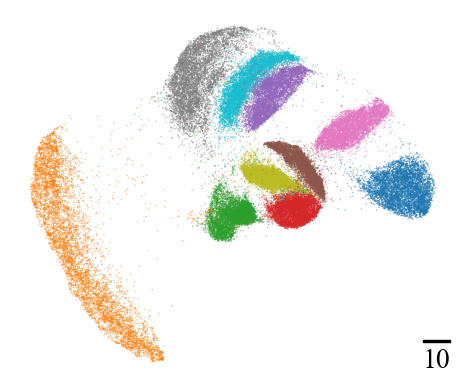

In [150]:
seed = 0
plt.figure()
plot_scatter(plt.gca(), trimappers[mode][seed].embedding_, y)

plt.savefig(os.path.join(fig_path,
                         f"trimap_default.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [151]:
mode = "kNN"
trimappers[mode] = []
for seed in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"trimap_mode_{mode}_seed_{seed}.pkl"
                             )
    try:
        with open(file_name, "rb") as file:
            trimapper = pickle.load(file)
    except FileNotFoundError:
        np.random.seed(seed)
        trimapper = trimap.TRIMAP(knn_tuple=(knn_graph, knn_dists),
                                                  n_inliers=15,
                                                  verbose=True).fit(pca50)

        with open(file_name, "wb") as file:
            pickle.dump(trimapper, file, pickle.HIGHEST_PROTOCOL)
    trimappers[mode].append(trimapper)


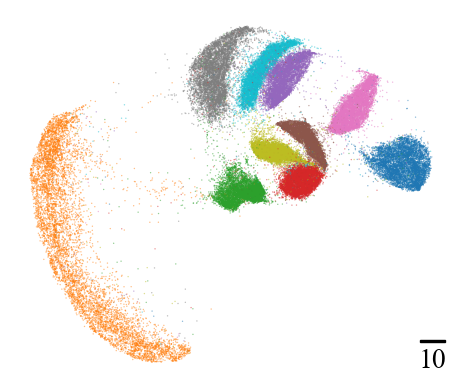

In [153]:
seed= 0
plt.figure()
plot_scatter(plt.gca(), trimappers[mode][seed].embedding_, y)
plt.savefig(os.path.join(fig_path,
                         f"trimap_kNN.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [154]:
mode = "no_rand"
trimappers[mode] = []
for seed in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"trimap_mode_{mode}_seed_{seed}.pkl"
                             )
    try:
        with open(file_name, "rb") as file:
            trimapper = pickle.load(file)
    except FileNotFoundError:
        np.random.seed(seed)
        trimapper = trimap.TRIMAP(knn_tuple=(knn_graph, knn_dists),
                                  n_inliers=15,
                                  n_random=0,
                                  verbose=True
                                  ).fit(pca50)

        with open(file_name, "wb") as file:
            pickle.dump(trimapper, file, pickle.HIGHEST_PROTOCOL)
    trimappers[mode].append(trimapper)


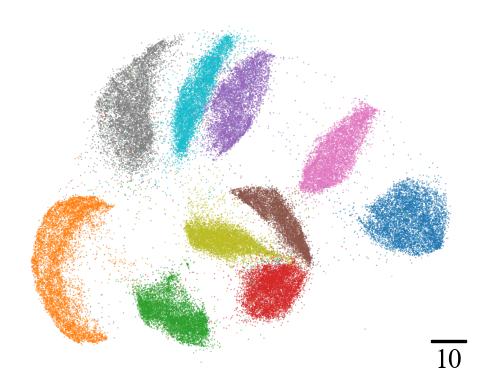

In [155]:
seed= 0
plt.figure()
plot_scatter(plt.gca(), trimappers[mode][seed].embedding_, y)
plt.savefig(os.path.join(fig_path,
                         f"trimap_no_rand.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [157]:
mode = "no_weights"
trimappers[mode] = []
for seed in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"trimap_mode_{mode}_seed_{seed}.pkl"
                             )

    file_name_no_rand = os.path.join(root_path, dataset,
                                     f"trimap_mode_no_rand_seed_{seed}.pkl")

    with open(file_name_no_rand, "rb") as file:
        trimapper_no_rand = pickle.load(file)

    triplets = trimapper_no_rand.triplets
    weights = np.ones(len(triplets)).astype(trimapper_no_rand.weights.dtype)

    try:
        with open(file_name, "rb") as file:
            trimapper = pickle.load(file)
    except FileNotFoundError:
        np.random.seed(seed)
        trimapper = trimap.TRIMAP(verbose=True,
                                  triplets=triplets,
                                  weights=weights
                                  ).fit(pca50)

        with open(file_name, "wb") as file:
            pickle.dump(trimapper, file, pickle.HIGHEST_PROTOCOL)
    trimappers[mode].append(trimapper)

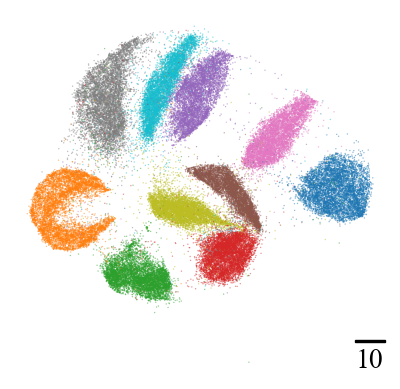

In [158]:
seed = 0
plt.figure()
plot_scatter(plt.gca(), trimappers[mode][seed].embedding_, y)
plt.savefig(os.path.join(fig_path,
                         f"trimap_no_weights.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [ ]:
# load infonc-tsne embedders for comparison, using different number of noise samples

In [144]:
# one noise sample
n_epochs = 750
init = "pca"
n_noise = 1
anneal_lr = True
optimizer= "sgd"
loss_mode = "infonce"
rescale = 1.0
batch_size = 1024
lr_min_factor = 0.0
momentum = 0.0
parametric = False
clamp_low = 1e-10

ince_embedders_1 = []

for seed in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_{init}_rescale_{rescale}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
    with open(file_name, "rb") as file:
        embedder = pickle.load(file)

    ince_embedders_1.append(embedder)
    print(f"done with seed={seed}")

done with seed=0
done with seed=1
done with seed=2


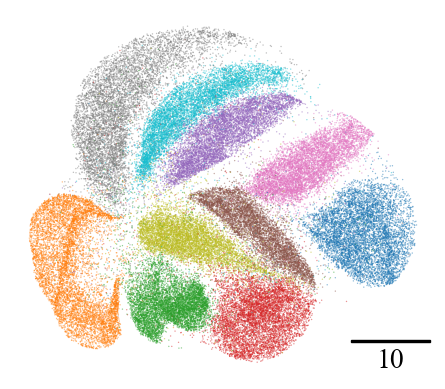

In [160]:
seed = 0
epoch = -1
plt.figure()
plot_scatter(plt.gca(), ince_embedders_1[seed].callback.embds[epoch], y)
plt.savefig(os.path.join(fig_path,
                         f"infonce_m_1.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [119]:
# five noise samples
n_epochs = 750
init = "pca"
n_noise = 5
anneal_lr = True
optimizer= "sgd"
loss_mode = "infonce"
rescale = 1.0
batch_size = 1024
lr_min_factor = 0.0
momentum = 0.0
parametric = False
clamp_low = 1e-10

ince_embedders_5 = []

for seed in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_{init}_rescale_{rescale}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
    with open(file_name, "rb") as file:
        embedder = pickle.load(file)

    ince_embedders_5.append(embedder)
    print(f"done with seed={seed}")

done with seed=0
done with seed=1
done with seed=2


<AxesSubplot:>

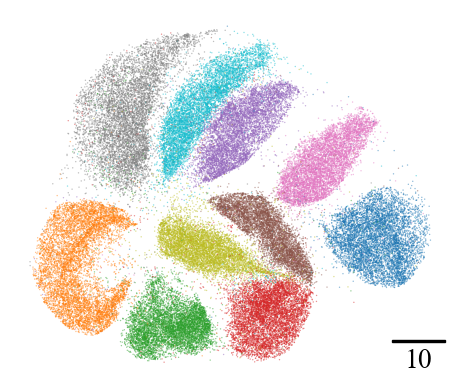

In [120]:
seed = 2
epoch = -1
plt.figure()
plot_scatter(plt.gca(), ince_embedders_5[seed].callback.embds[epoch], y)

# kNN accuraries

In [101]:
metrics = {}

In [102]:
k = 15

modes = ["vanilla", "kNN", "no_rand", "no_weights"]
metrics["knn_recall"] = {}
for mode in modes:
    recalls = []
    for seed in seeds:
        recalls.append(acc_kNN(trimappers[mode][seed].embedding_, pca50, k))
    recalls = np.stack(recalls)
    metrics["knn_recall"][mode] = {"mean": recalls.mean(),
                                   "std": recalls.std()}





In [124]:
recalls = []
for seed in seeds:
    recalls.append(acc_kNN(ince_embedders_1[seed].callback.embds[-1], pca50, k))
recalls = np.stack(recalls)
metrics["knn_recall"]["infonce_1"] = {"mean": recalls.mean(),
                               "std": recalls.std()}

recalls = []
for seed in seeds:
    recalls.append(acc_kNN(ince_embedders_5[seed].callback.embds[-1], pca50, k))
recalls = np.stack(recalls)
metrics["knn_recall"]["infonce_5"] = {"mean": recalls.mean(),
                               "std": recalls.std()}

In [125]:
for mode in modes+["infonce_1", "infonce_5"]:
    print(f"{mode}: {metrics['knn_recall'][mode]['mean']} +/- {metrics['knn_recall'][mode]['std']}")

vanilla: 0.09765079365079365 +/- 5.0636662158439266e-05
kNN: 0.09897428571428572 +/- 0.0004288725573477015
no_rand: 0.10136063492063492 +/- 0.0001608318010493343
no_weights: 0.09890031746031747 +/- 0.00033577548318344894
infonce_1: 0.08549460317460318 +/- 0.0005696089193364653
infonce_5: 0.10377396825396824 +/- 0.00015705208216695702


In [ ]:
%%time
metrics["p_corr"] = {}
metrics["s_corr"] = {}
for mode in modes:
    p_corrs = []
    s_corrs = []
    for seed in seeds:
        p_corr, s_corr = corr_pdist_subsample(trimappers[mode][seed].embedding_, pca50, sample_size=5000, seed=seed)
        p_corrs.append(p_corr)
        s_corrs.append(s_corr)

    p_corrs = np.stack(p_corrs)
    s_corrs = np.stack(s_corrs)
    metrics["p_corr"][mode] = {"mean": p_corrs.mean(),
                               "std": p_corrs.std()}
    metrics["s_corr"][mode] = {"mean": s_corrs.mean(),
                               "std": s_corrs.std()}


In [126]:

p_corrs = []
s_corrs = []
for seed in seeds:
    p_corr, s_corr = corr_pdist_subsample(ince_embedders_1[seed].callback.embds[-1], pca50, sample_size=5000, seed=seed)
    p_corrs.append(p_corr)
    s_corrs.append(s_corr)

p_corrs = np.stack(p_corrs)
s_corrs = np.stack(s_corrs)
metrics["p_corr"]["infonce_1"] = {"mean": p_corrs.mean(),
                                "std": p_corrs.std()}
metrics["s_corr"]["infonce_1"] = {"mean": s_corrs.mean(),
                                "std": s_corrs.std()}


p_corrs = []
s_corrs = []
for seed in seeds:
    p_corr, s_corr = corr_pdist_subsample(ince_embedders_5[seed].callback.embds[-1], pca50, sample_size=5000, seed=seed)
    p_corrs.append(p_corr)
    s_corrs.append(s_corr)

p_corrs = np.stack(p_corrs)
s_corrs = np.stack(s_corrs)
metrics["p_corr"]["infonce_5"] = {"mean": p_corrs.mean(),
                                "std": p_corrs.std()}
metrics["s_corr"]["infonce_5"] = {"mean": s_corrs.mean(),
                                "std": s_corrs.std()}

In [127]:
for mode in modes+["infonce_1", "infonce_5"]:
    print(f"{mode}: {metrics['p_corr'][mode]['mean']} +/- {metrics['p_corr'][mode]['std']}")

print("\n")

for mode in modes+["infonce", "infonce_5"]:
    print(f"{mode}: {metrics['s_corr'][mode]['mean']} +/- {metrics['s_corr'][mode]['std']}")

vanilla: 0.25032725885606316 +/- 0.008675325607066223
kNN: 0.19824481593169088 +/- 0.00316844896630471
no_rand: 0.3959426852566142 +/- 0.005038154008106477
no_weights: 0.42119448418093275 +/- 0.004404413139310247
infonce_1: 0.41277384608120576 +/- 0.006251617143186212
infonce_5: 0.40075894168849224 +/- 0.005266118790314295


vanilla: 0.24516961420788963 +/- 0.0052781949587138175
kNN: 0.23162781226726903 +/- 0.002870184707056989
no_rand: 0.35531626005103467 +/- 0.004468180546669974
no_weights: 0.3814587424848685 +/- 0.003888829393474414
infonce: 0.3805931597243724 +/- 0.00602404269524436
infonce_5: 0.3649480181126628 +/- 0.004985876312009968


# Loss analysis (not in paper)

In [23]:
steps = 1000
x = np.arange(1, steps+1)



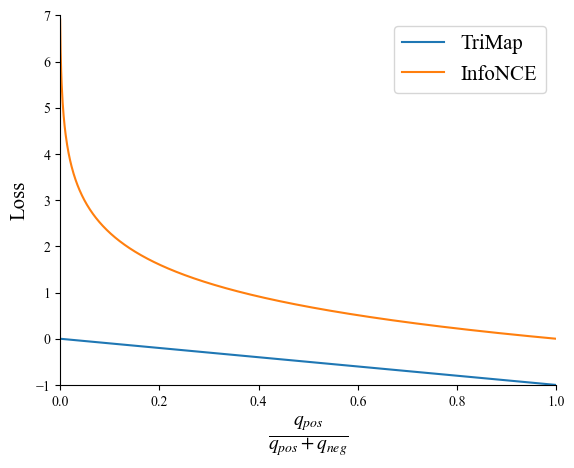

In [72]:
plt.figure()
plt.plot(- x / steps, label="TriMap")
plt.plot(-np.log(x / steps), label="InfoNCE")
plt.xticks(np.arange(steps+1)[::200], np.arange(steps+1)[::200]/steps)
plt.xlabel(r"$\frac{q_{pos}}{q_{pos} + q_{neg}}$", fontsize=20)
plt.ylabel("Loss", fontsize=15)
plt.legend(fontsize=15)
plt.ylim(-1, 7)
plt.xlim(0,1000)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.savefig(os.path.join(fig_path,
                         "tri_loss_info_loss_by_sim.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()

In [25]:

def cauchy(d):
    return 1 / (1+d**2)

def tri_loss(q_pos, q_neg):
    return - (q_pos / (q_pos + q_neg))

def info_loss(q_pos, q_neg):
    return - np.log(q_pos / (q_pos + q_neg))

def d_tri_loss_d_q_pos(q_pos, q_neg):
    return - q_neg / (q_pos + q_neg)**2

def d_tri_loss_d_q_neg(q_pos, q_neg):
    return q_pos / (q_pos + q_neg)**2

def d_info_loss_d_q_pos(q_pos, q_neg):
    return - q_neg / (q_pos * (q_pos + q_neg))

def d_info_loss_d_q_neg(q_pos, q_neg):
    return 1 / (q_pos + q_neg)


def tri_loss_by_d(d_pos, d_neg):
    return tri_loss(cauchy(d_pos), cauchy(d_neg))


def d_tri_loss_d_d_pos(d_pos, d_neg):
    return 2*d_pos * (d_neg**2+1) / (d_pos**2 + d_neg**2 + 2)**2

def d_tri_loss_d_d_neg(d_pos, d_neg):
    return -2 * (d_pos**2 +1) * d_neg / (d_pos**2 + d_neg**2 + 2)**2

def info_loss_by_d(d_pos, d_neg):
    return info_loss(cauchy(d_pos), cauchy(d_neg))

def d_info_loss_d_d_pos(d_pos, d_neg):
    return 2*d_pos / (d_pos**2 + d_neg**2 + 2)

def d_info_loss_d_d_neg(d_pos, d_neg):
    return - 2*(d_pos**2+1) * d_neg / ((d_neg**2+1) * (d_pos**2 + d_neg**2 +2))



In [10]:
q = np.arange(1,1001) / 1000

In [11]:
tri_l = tri_loss(q[:, None], q[None])

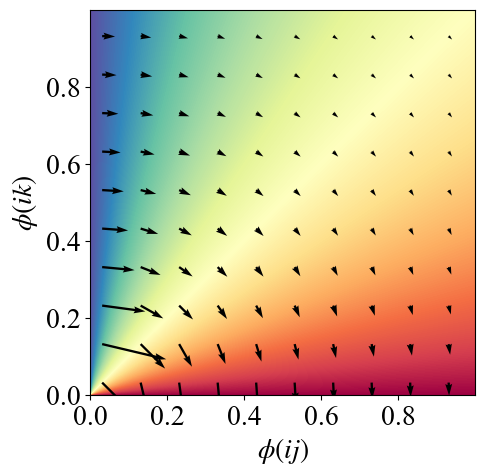

In [108]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 30

img = ax.imshow(tri_l.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$\phi(ij)$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.set_ylabel(r"$\phi(ik)$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.invert_yaxis()

q_pos, q_neg = np.meshgrid(q[low::subsample], q[low::subsample])
u = -d_tri_loss_d_q_pos(q_pos, q_neg)
v = -d_tri_loss_d_q_neg(q_pos, q_neg)

ax.quiver(np.arange(1, 1001)[low::subsample], np.arange(1, 1001)[low::subsample], u,v, scale=30, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "tri_loss_by_sim.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()

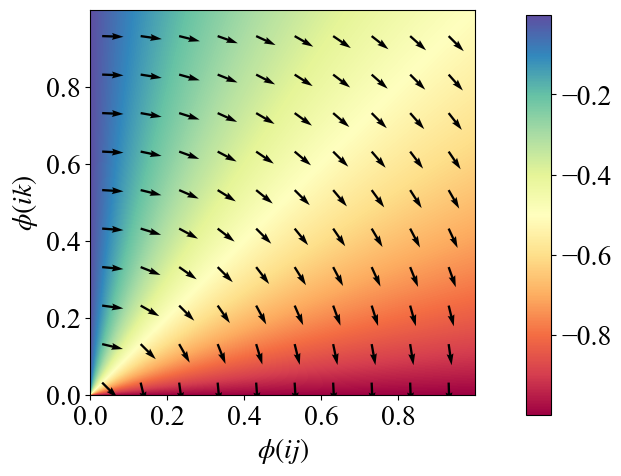

In [110]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 30

img = ax.imshow(tri_l.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$\phi(ij)$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.set_ylabel(r"$\phi(ik)$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.invert_yaxis()

cax = fig.add_axes([1, 0.07, 0.05, 0.8])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)

q_pos, q_neg = np.meshgrid(q[low::subsample], q[low::subsample])
u = -d_tri_loss_d_q_pos(q_pos, q_neg)
v = -d_tri_loss_d_q_neg(q_pos, q_neg)


norm = np.linalg.norm(np.array((u, v)), axis=0)
u_norm = u / norm
v_norm = v / norm


ax.quiver(np.arange(1, 1001)[low::subsample], np.arange(1, 1001)[low::subsample], u_norm, v_norm, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "tri_loss_by_sim_norm.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()

In [13]:
info_l = info_loss(q[:, None], q[None])

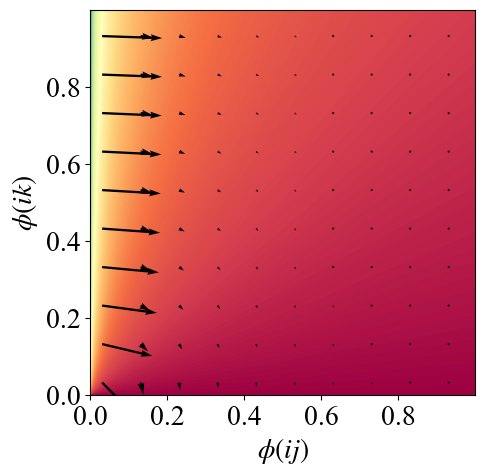

In [113]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 30

img = ax.imshow(info_l.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$\phi(ij)$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.set_ylabel(r"$\phi(ik)$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.invert_yaxis()



q_pos, q_neg = np.meshgrid(q[low::subsample], q[low::subsample])
u = -d_info_loss_d_q_pos(q_pos, q_neg)
v = -d_info_loss_d_q_neg(q_pos, q_neg)


ax.quiver(np.arange(1, 1001)[low::subsample], np.arange(1, 1001)[low::subsample], u,v, scale=200, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "info_loss_by_sim.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()

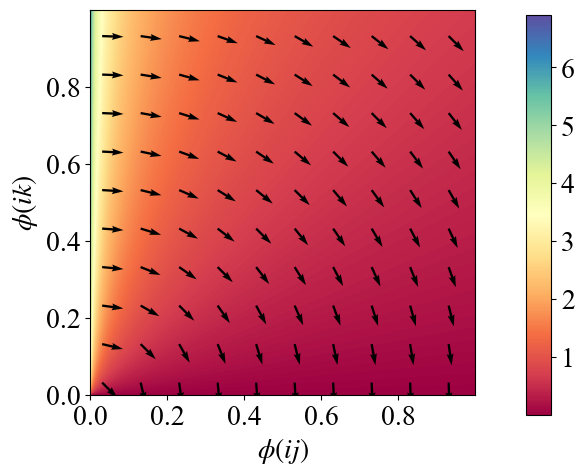

In [114]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 30
img = ax.imshow(info_l.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$\phi(ij)$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.set_ylabel(r"$\phi(ik)$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(np.arange(0, 1000)[::200] / 1000, fontsize=20)
ax.invert_yaxis()

cax = fig.add_axes([1, 0.07, 0.05, 0.8])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)


q_pos, q_neg = np.meshgrid(q[low::subsample], q[low::subsample])
u = -d_info_loss_d_q_pos(q_pos, q_neg)
v = -d_info_loss_d_q_neg(q_pos, q_neg)


norm = np.linalg.norm(np.array((u, v)), axis=0)
u_norm = u / norm
v_norm = v / norm


ax.quiver(np.arange(1, 1001)[low::subsample], np.arange(1, 1001)[low::subsample], u_norm, v_norm, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "info_loss_by_sim_norm.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()

In [15]:
# losses by distances

In [26]:
d = np.arange(0, 1000) / 10


In [27]:
tri_l_by_d = tri_loss_by_d(d[:, None], d[None])

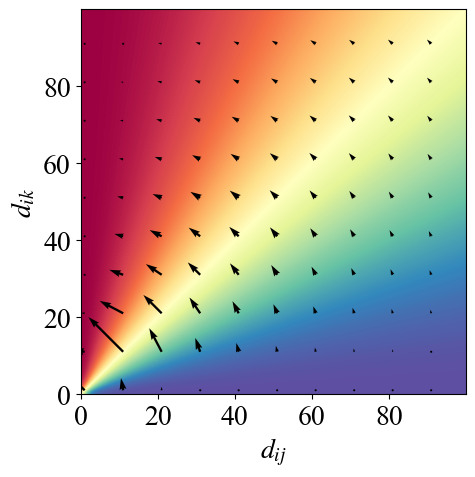

In [115]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 10

img = ax.imshow(tri_l_by_d.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$d_{ij}$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(d[::200].astype(int), fontsize=20)
ax.set_ylabel(r"$d_{ik}$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(d[::200].astype(int), fontsize=20)
ax.invert_yaxis()

d_pos, d_neg = np.meshgrid(d[low::subsample], d[low::subsample])
u = -d_tri_loss_d_d_pos(d_pos, d_neg)
v = -d_tri_loss_d_d_neg(d_pos, d_neg)

ax.quiver(np.arange(1000)[low::subsample], np.arange(1000)[low::subsample], u,v, scale=0.5, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "tri_loss_by_d.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()


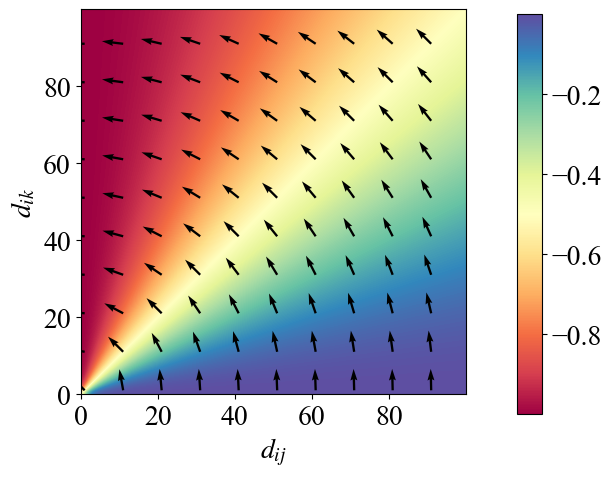

In [116]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 10

img = ax.imshow(tri_l_by_d.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$d_{ij}$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(d[::200].astype(int), fontsize=20)
ax.set_ylabel(r"$d_{ik}$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(d[::200].astype(int), fontsize=20)
ax.invert_yaxis()

cax = fig.add_axes([1, 0.07, 0.05, 0.8])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)



d_pos, d_neg = np.meshgrid(d[low::subsample], d[low::subsample])
u = -d_tri_loss_d_d_pos(d_pos, d_neg)
v = -d_tri_loss_d_d_neg(d_pos, d_neg)


norm = np.linalg.norm(np.array((u, v)), axis=0)
u_norm = u / norm
v_norm = v / norm


ax.quiver(np.arange(1000)[low::subsample], np.arange(1000)[low::subsample], u_norm, v_norm, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "tri_loss_by_d_norm.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()


In [28]:
info_l_by_d = info_loss_by_d(d[:, None], d[None])

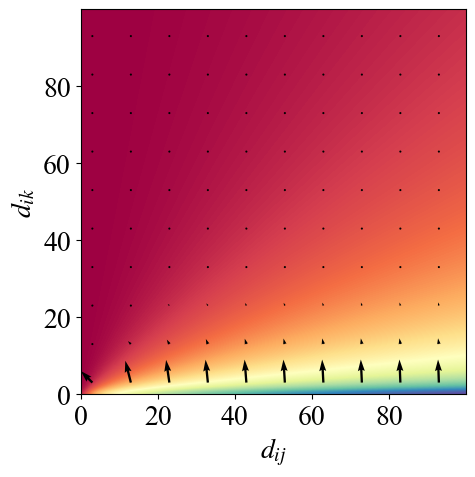

In [117]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 30

img = ax.imshow(info_l_by_d.T, cmap="Spectral")
ax.set_xlabel(r"$d_{ij}$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(d[::200].astype(int), fontsize=20)
ax.set_ylabel(r"$d_{ik}$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(d[::200].astype(int), fontsize=20)
ax.invert_yaxis()

d_pos, d_neg = np.meshgrid(d[low::subsample], d[low::subsample])
u = -d_info_loss_d_d_pos(d_pos, d_neg)
v = -d_info_loss_d_d_neg(d_pos, d_neg)

ax.quiver(np.arange(1000)[low::subsample], np.arange(1000)[low::subsample], u,v,scale = 10, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "info_loss_by_d.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()

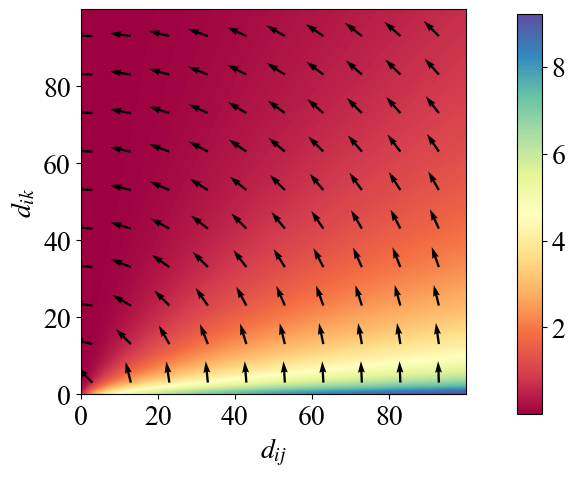

In [118]:
fig, ax = plt.subplots(figsize=(5,5))

subsample = 100
low = 30

img = ax.imshow(info_l_by_d.T, cmap="Spectral")
#plt.contour(heat_infonce, colors="k", levels = 20)
ax.set_xlabel(r"$d_{ij}$", fontsize=20)
ax.set_xticks(np.arange(0, 1000)[::200])
ax.set_xticklabels(d[::200].astype(int), fontsize=20)
ax.set_ylabel(r"$d_{ik}$", fontsize=20)
ax.set_yticks(np.arange(0, 1000)[::200])
ax.set_yticklabels(d[::200].astype(int), fontsize=20)
ax.invert_yaxis()



cax = fig.add_axes([1, 0.07, 0.05, 0.8])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)



d_pos, d_neg = np.meshgrid(d[low::subsample], d[low::subsample])
u = -d_info_loss_d_d_pos(d_pos, d_neg)
v = -d_info_loss_d_d_neg(d_pos, d_neg)


norm = np.linalg.norm(np.array((u, v)), axis=0)
u_norm = u / norm
v_norm = v / norm


ax.quiver(np.arange(1000)[low::subsample], np.arange(1000)[low::subsample], u_norm, v_norm, angles="xy", zorder=5, color="k")

fig.savefig(os.path.join(fig_path,
                         "info_loss_by_d_norm.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
#plt.close()